## Cell 1: Imports and Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Cell 2: Define the Neural Network Architecture

In [11]:
class MNISTNet(nn.Module):
    """
    Neural network for MNIST classification.
    Architecture from Hinton's paper:
    - 2 hidden layers with ReLU activation
    - Configurable number of units per layer
    """
    def __init__(self, hidden_size=1200, dropout_rate=0.5):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, temperature=1.0):
        """
        Forward pass with optional temperature scaling.
        
        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28) or (batch_size, 28, 28) or (batch_size, 784)
            temperature: Temperature for softmax (default: 1.0)
        
        Returns:
            logits: Raw logits before softmax
            probs: Softmax probabilities (with temperature)
        """
        # Flatten input - handle all possible input shapes
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten to (batch_size, 784)
        
        # Forward pass through layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)
        
        # Apply temperature scaling and softmax
        probs = F.softmax(logits / temperature, dim=1)
        
        return logits, probs

# Test the architecture
model = MNISTNet(hidden_size=1200).to(device)
print(f"Teacher model parameters: {sum(p.numel() for p in model.parameters()):,}")

student_model = MNISTNet(hidden_size=800, dropout_rate=0.0).to(device)
print(f"Student model parameters: {sum(p.numel() for p in student_model.parameters()):,}")

# Test with sample input to verify shapes
sample_input = torch.randn(32, 1, 28, 28).to(device)  # Batch of 32 MNIST images
logits, probs = model(sample_input)
print(f"\nTest forward pass:")
print(f"  Input shape: {sample_input.shape}")
print(f"  Logits shape: {logits.shape}")
print(f"  Probs shape: {probs.shape}")
print(f"  Probs sum (should be ~1.0): {probs[0].sum().item():.4f}")

Teacher model parameters: 2,395,210
Student model parameters: 1,276,810

Test forward pass:
  Input shape: torch.Size([32, 1, 28, 28])
  Logits shape: torch.Size([32, 10])
  Probs shape: torch.Size([32, 10])
  Probs sum (should be ~1.0): 1.0000


## Cell 3: Load MNIST Data

Full training set size: 60000
Test set size: 10000


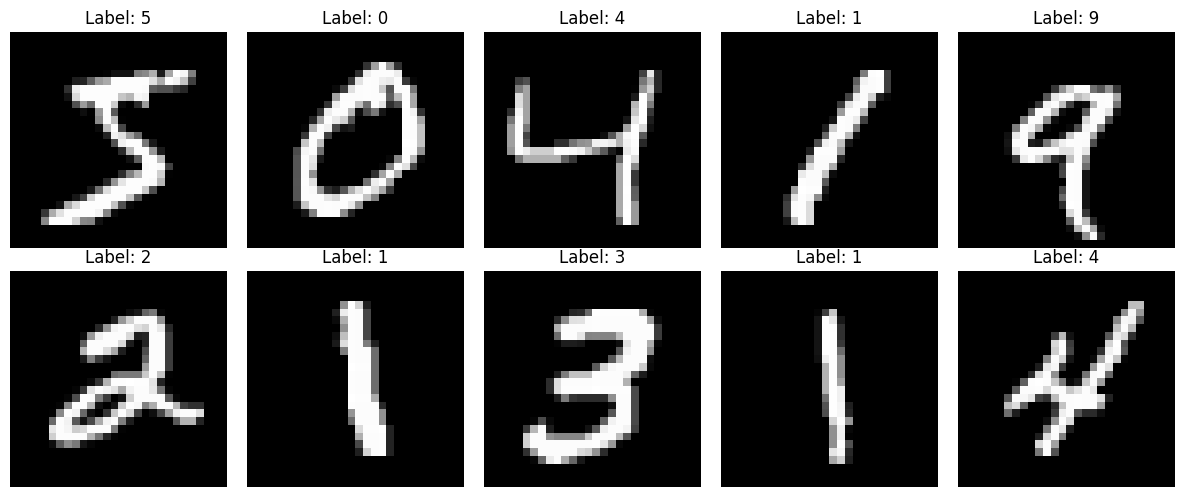

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load full MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Full training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Cell 4: Create Dataset Without Digit 3

In [6]:
def create_filtered_dataset(dataset, excluded_digit):
    """
    Create a dataset excluding a specific digit.
    
    Args:
        dataset: Original MNIST dataset
        excluded_digit: Digit to exclude (0-9)
    
    Returns:
        Subset of dataset without the excluded digit
    """
    # Find indices where target != excluded_digit
    indices = [i for i, (_, label) in enumerate(dataset) if label != excluded_digit]
    return Subset(dataset, indices)

# Create training set WITHOUT digit 3
train_without_3 = create_filtered_dataset(train_dataset, excluded_digit=3)
print(f"Training set without '3': {len(train_without_3)} samples")
print(f"Removed samples: {len(train_dataset) - len(train_without_3)}")

# Count remaining digits
remaining_labels = [train_dataset[i][1] for i in train_without_3.indices]
unique, counts = np.unique(remaining_labels, return_counts=True)
print("\nClass distribution (without 3):")
for digit, count in zip(unique, counts):
    print(f"  Digit {digit}: {count} samples")

# Create dataloaders
batch_size = 128
train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_no_3 = DataLoader(train_without_3, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set without '3': 53869 samples
Removed samples: 6131

Class distribution (without 3):
  Digit 0: 5923 samples
  Digit 1: 6742 samples
  Digit 2: 5958 samples
  Digit 4: 5842 samples
  Digit 5: 5421 samples
  Digit 6: 5918 samples
  Digit 7: 6265 samples
  Digit 8: 5851 samples
  Digit 9: 5949 samples


## Cell 5: Training Functions

In [9]:
def train_teacher(model, train_loader, epochs=10, lr=0.001):
    """
    Train the teacher model with standard cross-entropy loss.
    Includes dropout and weight regularization.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            logits, probs = model(data, temperature=1.0)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = probs.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': total_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        
        print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.2f}%')
    
    return history

def evaluate(model, test_loader, temperature=1.0):
    """
    Evaluate model on test set.
    """
    model.eval()
    correct = 0
    total = 0
    correct_per_class = {i: 0 for i in range(10)}
    total_per_class = {i: 0 for i in range(10)}
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits, probs = model(data, temperature=temperature)
            pred = probs.argmax(dim=1)
            
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            # Per-class accuracy
            for t, p in zip(target, pred):
                total_per_class[t.item()] += 1
                if t == p:
                    correct_per_class[t.item()] += 1
    
    accuracy = 100. * correct / total
    print(f'\nOverall Test Accuracy: {accuracy:.2f}% ({total - correct} errors out of {total})')
    
    print('\nPer-class accuracy:')
    for digit in range(10):
        if total_per_class[digit] > 0:
            class_acc = 100. * correct_per_class[digit] / total_per_class[digit]
            errors = total_per_class[digit] - correct_per_class[digit]
            print(f'  Digit {digit}: {class_acc:.2f}% ({errors} errors out of {total_per_class[digit]})')
    
    return accuracy, correct_per_class, total_per_class

## Cell 6: Train the Teacher Model

In [12]:
print("=" * 60)
print("TRAINING TEACHER MODEL (with all digits including 3)")
print("=" * 60)

# Initialize teacher model
teacher_model = MNISTNet(hidden_size=1200, dropout_rate=0.5).to(device)

# Train on full dataset
teacher_history = train_teacher(teacher_model, train_loader_full, epochs=10, lr=0.001)

# Evaluate teacher
print("\n" + "=" * 60)
print("TEACHER MODEL EVALUATION")
print("=" * 60)
teacher_acc, _, _ = evaluate(teacher_model, test_loader, temperature=1.0)

TRAINING TEACHER MODEL (with all digits including 3)


Epoch 1/10: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s, loss=0.276, acc=91.5]


Epoch 1: Loss=0.2755, Accuracy=91.51%


Epoch 2/10: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s, loss=0.153, acc=95.2]


Epoch 2: Loss=0.1529, Accuracy=95.25%


Epoch 3/10: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s, loss=0.125, acc=96.2]


Epoch 3: Loss=0.1252, Accuracy=96.21%


Epoch 4/10: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s, loss=0.117, acc=96.4]


Epoch 4: Loss=0.1171, Accuracy=96.43%


Epoch 5/10: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s, loss=0.109, acc=96.8]


Epoch 5: Loss=0.1094, Accuracy=96.75%


Epoch 6/10: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s, loss=0.106, acc=96.8] 


Epoch 6: Loss=0.1057, Accuracy=96.83%


Epoch 7/10: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s, loss=0.099, acc=97]   


Epoch 7: Loss=0.0990, Accuracy=97.03%


Epoch 8/10: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s, loss=0.096, acc=97]   


Epoch 8: Loss=0.0960, Accuracy=97.00%


Epoch 9/10: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s, loss=0.0952, acc=97.1]


Epoch 9: Loss=0.0952, Accuracy=97.14%


Epoch 10/10: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s, loss=0.0902, acc=97.3]


Epoch 10: Loss=0.0902, Accuracy=97.28%

TEACHER MODEL EVALUATION

Overall Test Accuracy: 97.85% (215 errors out of 10000)

Per-class accuracy:
  Digit 0: 99.39% (6 errors out of 980)
  Digit 1: 99.12% (10 errors out of 1135)
  Digit 2: 96.71% (34 errors out of 1032)
  Digit 3: 98.51% (15 errors out of 1010)
  Digit 4: 98.68% (13 errors out of 982)
  Digit 5: 95.52% (40 errors out of 892)
  Digit 6: 97.70% (22 errors out of 958)
  Digit 7: 99.22% (8 errors out of 1028)
  Digit 8: 97.33% (26 errors out of 974)
  Digit 9: 95.94% (41 errors out of 1009)


## Cell 7: Distillation Training Function


In [13]:
def train_student_with_distillation(student, teacher, train_loader, 
                                   temperature=20, alpha=0.5, epochs=10, lr=0.001):
    """
    Train student model using knowledge distillation.
    
    Args:
        student: Student model
        teacher: Teacher model (pretrained)
        train_loader: DataLoader for training
        temperature: Temperature for distillation (T)
        alpha: Weight for hard target loss (1-alpha for soft targets)
        epochs: Number of training epochs
        lr: Learning rate
    """
    student.train()
    teacher.eval()  # Teacher in eval mode
    
    optimizer = optim.Adam(student.parameters(), lr=lr)
    hard_loss_fn = nn.CrossEntropyLoss()
    soft_loss_fn = nn.KLDivLoss(reduction='batchmean')
    
    history = {'total_loss': [], 'soft_loss': [], 'hard_loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        total_loss_sum = 0
        soft_loss_sum = 0
        hard_loss_sum = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            # Student forward pass
            student_logits, student_probs_temp = student(data, temperature=temperature)
            _, student_probs = student(data, temperature=1.0)  # For accuracy calculation
            
            # Teacher forward pass (no gradient)
            with torch.no_grad():
                _, teacher_probs_temp = teacher(data, temperature=temperature)
            
            # Soft target loss (KL divergence)
            # Note: KLDivLoss expects log probabilities as input
            soft_loss = soft_loss_fn(
                F.log_softmax(student_logits / temperature, dim=1),
                teacher_probs_temp
            )
            
            # Hard target loss (standard cross-entropy)
            hard_loss = hard_loss_fn(student_logits, target)
            
            # Combined loss with T^2 scaling for soft loss (as per paper)
            loss = (temperature ** 2) * (1 - alpha) * soft_loss + alpha * hard_loss
            
            loss.backward()
            optimizer.step()
            
            # Statistics
            total_loss_sum += loss.item()
            soft_loss_sum += soft_loss.item()
            hard_loss_sum += hard_loss.item()
            
            pred = student_probs.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': total_loss_sum / (batch_idx + 1),
                'soft': soft_loss_sum / (batch_idx + 1),
                'hard': hard_loss_sum / (batch_idx + 1),
                'acc': 100. * correct / total
            })
        
        avg_total_loss = total_loss_sum / len(train_loader)
        avg_soft_loss = soft_loss_sum / len(train_loader)
        avg_hard_loss = hard_loss_sum / len(train_loader)
        accuracy = 100. * correct / total
        
        history['total_loss'].append(avg_total_loss)
        history['soft_loss'].append(avg_soft_loss)
        history['hard_loss'].append(avg_hard_loss)
        history['accuracy'].append(accuracy)
        
        print(f'Epoch {epoch+1}: Total Loss={avg_total_loss:.4f}, '
              f'Soft Loss={avg_soft_loss:.4f}, Hard Loss={avg_hard_loss:.4f}, '
              f'Accuracy={accuracy:.2f}%')
    
    return history

## Cell 8: Train Student WITHOUT seeing digit 3

In [14]:
print("=" * 60)
print("TRAINING STUDENT MODEL (WITHOUT digit 3 in training data)")
print("=" * 60)
print(f"Using Temperature T={20}")
print(f"Using alpha (hard target weight)={0.5}")
print()

# Initialize student model (smaller, no dropout)
student_model = MNISTNet(hidden_size=800, dropout_rate=0.0).to(device)

# Train with distillation on dataset without 3s
student_history = train_student_with_distillation(
    student=student_model,
    teacher=teacher_model,
    train_loader=train_loader_no_3,
    temperature=20,
    alpha=0.5,
    epochs=10,
    lr=0.001
)

TRAINING STUDENT MODEL (WITHOUT digit 3 in training data)
Using Temperature T=20
Using alpha (hard target weight)=0.5



Epoch 1/10: 100%|██████████| 421/421 [00:16<00:00, 25.99it/s, loss=1.28, soft=0.00587, hard=0.208, acc=94.4]


Epoch 1: Total Loss=1.2774, Soft Loss=0.0059, Hard Loss=0.2080, Accuracy=94.39%


Epoch 2/10: 100%|██████████| 421/421 [00:18<00:00, 23.29it/s, loss=0.183, soft=0.000786, hard=0.0525, acc=98.4]


Epoch 2: Total Loss=0.1835, Soft Loss=0.0008, Hard Loss=0.0525, Accuracy=98.44%


Epoch 3/10: 100%|██████████| 421/421 [00:17<00:00, 23.39it/s, loss=0.124, soft=0.000532, hard=0.0361, acc=98.9]


Epoch 3: Total Loss=0.1244, Soft Loss=0.0005, Hard Loss=0.0361, Accuracy=98.91%


Epoch 4/10: 100%|██████████| 421/421 [00:17<00:00, 23.65it/s, loss=0.106, soft=0.00046, hard=0.0289, acc=99.2] 


Epoch 4: Total Loss=0.1064, Soft Loss=0.0005, Hard Loss=0.0289, Accuracy=99.18%


Epoch 5/10: 100%|██████████| 421/421 [00:18<00:00, 23.27it/s, loss=0.0877, soft=0.000378, hard=0.0244, acc=99.4]


Epoch 5: Total Loss=0.0877, Soft Loss=0.0004, Hard Loss=0.0244, Accuracy=99.37%


Epoch 6/10: 100%|██████████| 421/421 [00:16<00:00, 25.90it/s, loss=0.0838, soft=0.000364, hard=0.0222, acc=99.4]


Epoch 6: Total Loss=0.0838, Soft Loss=0.0004, Hard Loss=0.0222, Accuracy=99.43%


Epoch 7/10: 100%|██████████| 421/421 [00:16<00:00, 25.78it/s, loss=0.079, soft=0.000346, hard=0.0197, acc=99.5] 


Epoch 7: Total Loss=0.0790, Soft Loss=0.0003, Hard Loss=0.0197, Accuracy=99.53%


Epoch 8/10: 100%|██████████| 421/421 [00:15<00:00, 27.39it/s, loss=0.0677, soft=0.000293, hard=0.0182, acc=99.6]


Epoch 8: Total Loss=0.0677, Soft Loss=0.0003, Hard Loss=0.0182, Accuracy=99.60%


Epoch 9/10: 100%|██████████| 421/421 [00:14<00:00, 28.74it/s, loss=0.0659, soft=0.000287, hard=0.0172, acc=99.7]


Epoch 9: Total Loss=0.0659, Soft Loss=0.0003, Hard Loss=0.0172, Accuracy=99.66%


Epoch 10/10: 100%|██████████| 421/421 [00:14<00:00, 28.52it/s, loss=0.0662, soft=0.000289, hard=0.0166, acc=99.7]

Epoch 10: Total Loss=0.0662, Soft Loss=0.0003, Hard Loss=0.0166, Accuracy=99.69%


## Cell 9: Evaluate Student on Test Set (Including 3s!)

In [15]:
print("\n" + "=" * 60)
print("STUDENT MODEL EVALUATION (including mythical digit 3!)")
print("=" * 60)

student_acc, student_correct, student_total = evaluate(student_model, test_loader, temperature=1.0)

# Focus on digit 3 performance
digit_3_accuracy = 100. * student_correct[3] / student_total[3]
digit_3_errors = student_total[3] - student_correct[3]

print("\n" + "=" * 60)
print("MYTHICAL DIGIT 3 ANALYSIS")
print("=" * 60)
print(f"The student NEVER saw any 3s during training!")
print(f"Digit 3 test accuracy: {digit_3_accuracy:.2f}%")
print(f"Digit 3 errors: {digit_3_errors} out of {student_total[3]}")
print(f"\nThis means the student learned to recognize 3s with {digit_3_accuracy:.1f}% accuracy")
print(f"purely from the teacher's soft targets on OTHER digits!")


STUDENT MODEL EVALUATION (including mythical digit 3!)

Overall Test Accuracy: 97.79% (221 errors out of 10000)

Per-class accuracy:
  Digit 0: 99.59% (4 errors out of 980)
  Digit 1: 99.21% (9 errors out of 1135)
  Digit 2: 97.97% (21 errors out of 1032)
  Digit 3: 93.37% (67 errors out of 1010)
  Digit 4: 98.68% (13 errors out of 982)
  Digit 5: 97.87% (19 errors out of 892)
  Digit 6: 98.23% (17 errors out of 958)
  Digit 7: 98.35% (17 errors out of 1028)
  Digit 8: 97.13% (28 errors out of 974)
  Digit 9: 97.42% (26 errors out of 1009)

MYTHICAL DIGIT 3 ANALYSIS
The student NEVER saw any 3s during training!
Digit 3 test accuracy: 93.37%
Digit 3 errors: 67 out of 1010

This means the student learned to recognize 3s with 93.4% accuracy
purely from the teacher's soft targets on OTHER digits!


## Cell 10: Bias Correction (as mentioned in paper)

In [16]:
def evaluate_with_bias_correction(model, test_loader, bias_adjustments):
    """
    Evaluate model with bias corrections applied to specific classes.
    
    Args:
        model: The model to evaluate
        test_loader: DataLoader for test set
        bias_adjustments: Dict mapping class_id -> bias value to add to logits
    """
    model.eval()
    correct = 0
    total = 0
    correct_per_class = {i: 0 for i in range(10)}
    total_per_class = {i: 0 for i in range(10)}
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data, temperature=1.0)
            
            # Apply bias corrections
            for class_id, bias in bias_adjustments.items():
                logits[:, class_id] += bias
            
            # Get predictions with corrected logits
            probs = F.softmax(logits, dim=1)
            pred = probs.argmax(dim=1)
            
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            # Per-class accuracy
            for t, p in zip(target, pred):
                total_per_class[t.item()] += 1
                if t == p:
                    correct_per_class[t.item()] += 1
    
    accuracy = 100. * correct / total
    print(f'Overall Test Accuracy (with bias correction): {accuracy:.2f}% ({total - correct} errors)')
    
    print('\nPer-class accuracy:')
    for digit in range(10):
        if total_per_class[digit] > 0:
            class_acc = 100. * correct_per_class[digit] / total_per_class[digit]
            errors = total_per_class[digit] - correct_per_class[digit]
            print(f'  Digit {digit}: {class_acc:.2f}% ({errors} errors out of {total_per_class[digit]})')
    
    return accuracy, correct_per_class, total_per_class

print("\n" + "=" * 60)
print("BIAS CORRECTION EXPERIMENT")
print("=" * 60)
print("As mentioned in the paper, we can improve performance by")
print("adjusting the bias for the mythical digit 3")
print()

# Try different bias values for digit 3
best_bias = 0
best_accuracy = student_acc
best_digit_3_accuracy = digit_3_accuracy

print("Testing different bias adjustments for digit 3:")
for bias in np.arange(-5, 8, 0.5):
    bias_adj = {3: bias}
    acc, corr, tot = evaluate_with_bias_correction(student_model, test_loader, bias_adj)
    d3_acc = 100. * corr[3] / tot[3]
    
    print(f"Bias={bias:+.1f}: Overall={acc:.2f}%, Digit 3={d3_acc:.2f}%")
    
    if d3_acc > best_digit_3_accuracy:
        best_bias = bias
        best_accuracy = acc
        best_digit_3_accuracy = d3_acc

print(f"\n" + "=" * 60)
print(f"Best bias for digit 3: {best_bias:+.1f}")
print(f"Best overall accuracy: {best_accuracy:.2f}%")
print(f"Best digit 3 accuracy: {best_digit_3_accuracy:.2f}%")
print("=" * 60)


BIAS CORRECTION EXPERIMENT
As mentioned in the paper, we can improve performance by
adjusting the bias for the mythical digit 3

Testing different bias adjustments for digit 3:
Overall Test Accuracy (with bias correction): 93.99% (601 errors)

Per-class accuracy:
  Digit 0: 99.59% (4 errors out of 980)
  Digit 1: 99.21% (9 errors out of 1135)
  Digit 2: 97.97% (21 errors out of 1032)
  Digit 3: 55.45% (450 errors out of 1010)
  Digit 4: 98.68% (13 errors out of 982)
  Digit 5: 98.09% (17 errors out of 892)
  Digit 6: 98.23% (17 errors out of 958)
  Digit 7: 98.35% (17 errors out of 1028)
  Digit 8: 97.23% (27 errors out of 974)
  Digit 9: 97.42% (26 errors out of 1009)
Bias=-5.0: Overall=93.99%, Digit 3=55.45%
Overall Test Accuracy (with bias correction): 94.48% (552 errors)

Per-class accuracy:
  Digit 0: 99.59% (4 errors out of 980)
  Digit 1: 99.21% (9 errors out of 1135)
  Digit 2: 97.97% (21 errors out of 1032)
  Digit 3: 60.30% (401 errors out of 1010)
  Digit 4: 98.68% (13 erro

## Cell 11: Visualize What the Student Learned About 3s

Visualizing student's predictions on digit 3 (the mythical digit)

Without bias correction:


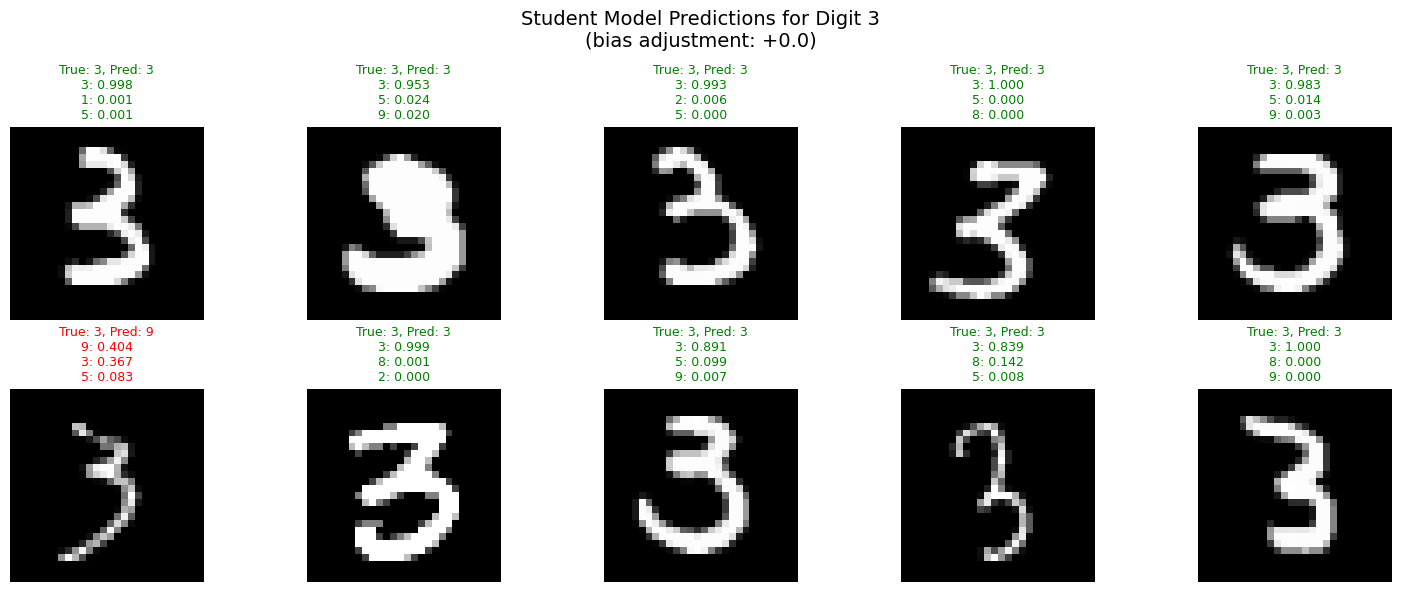


With optimal bias correction:


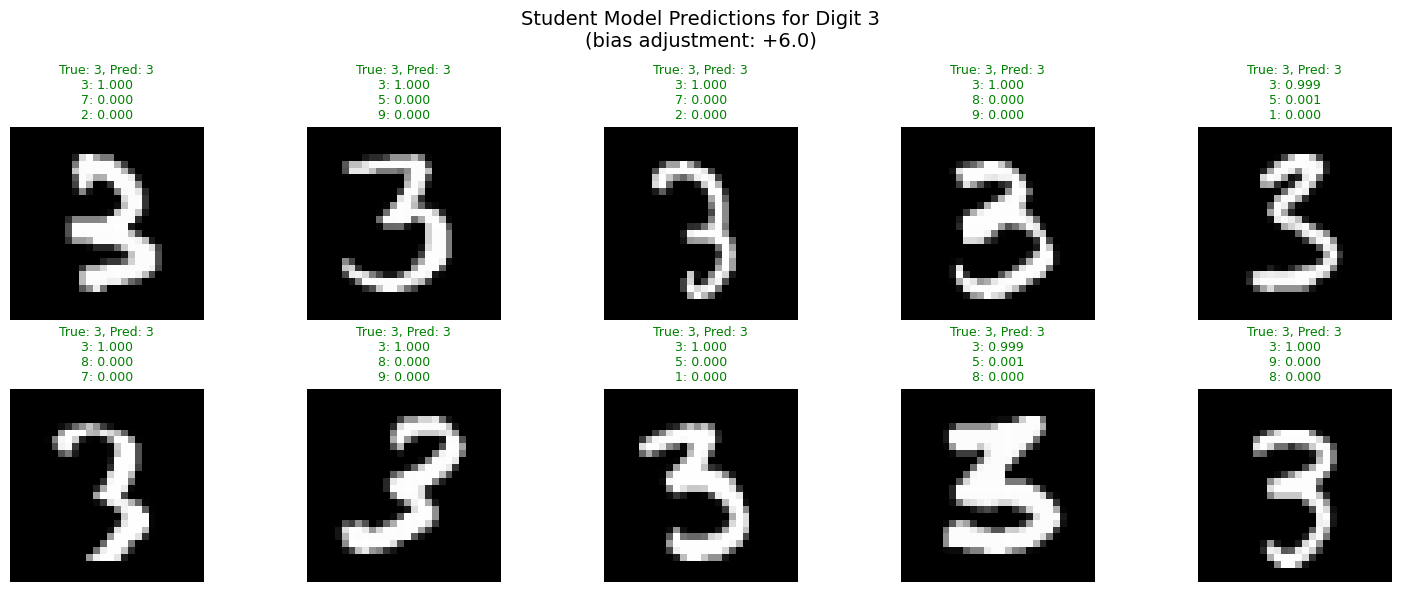

In [17]:
def visualize_predictions(model, dataset, digit, num_examples=10, bias_adjustment=0):
    """
    Visualize model predictions for a specific digit.
    """
    model.eval()
    
    # Find examples of the specified digit
    indices = [i for i, (_, label) in enumerate(dataset) if label == digit]
    selected_indices = np.random.choice(indices, min(num_examples, len(indices)), replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    with torch.no_grad():
        for idx, img_idx in enumerate(selected_indices):
            img, true_label = dataset[img_idx]
            img_tensor = img.unsqueeze(0).to(device)
            
            logits, probs = model(img_tensor, temperature=1.0)
            
            # Apply bias if specified
            if bias_adjustment != 0:
                logits[0, digit] += bias_adjustment
                probs = F.softmax(logits, dim=1)
            
            pred = probs.argmax().item()
            confidence = probs[0, pred].item()
            
            # Show image
            axes[idx].imshow(img.squeeze(), cmap='gray')
            
            # Show top 3 predictions
            top3_probs, top3_indices = torch.topk(probs[0], 3)
            pred_text = '\n'.join([f'{top3_indices[i].item()}: {top3_probs[i].item():.3f}' 
                                   for i in range(3)])
            
            color = 'green' if pred == true_label else 'red'
            axes[idx].set_title(f'True: {true_label}, Pred: {pred}\n{pred_text}', 
                               color=color, fontsize=9)
            axes[idx].axis('off')
    
    plt.suptitle(f'Student Model Predictions for Digit {digit}\n'
                 f'(bias adjustment: {bias_adjustment:+.1f})', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Visualizing student's predictions on digit 3 (the mythical digit)")
print("\nWithout bias correction:")
visualize_predictions(student_model, test_dataset, digit=3, num_examples=10, bias_adjustment=0)

print("\nWith optimal bias correction:")
visualize_predictions(student_model, test_dataset, digit=3, num_examples=10, bias_adjustment=best_bias)

## Cell 12: Compare Soft Targets - What Did the Student Learn?


ANALYZING HOW THE STUDENT LEARNED ABOUT 3s

The student never saw any 3s during training.
But the teacher provided soft targets on OTHER digits.
Let's see what probability the teacher assigned to '3' on other digits:



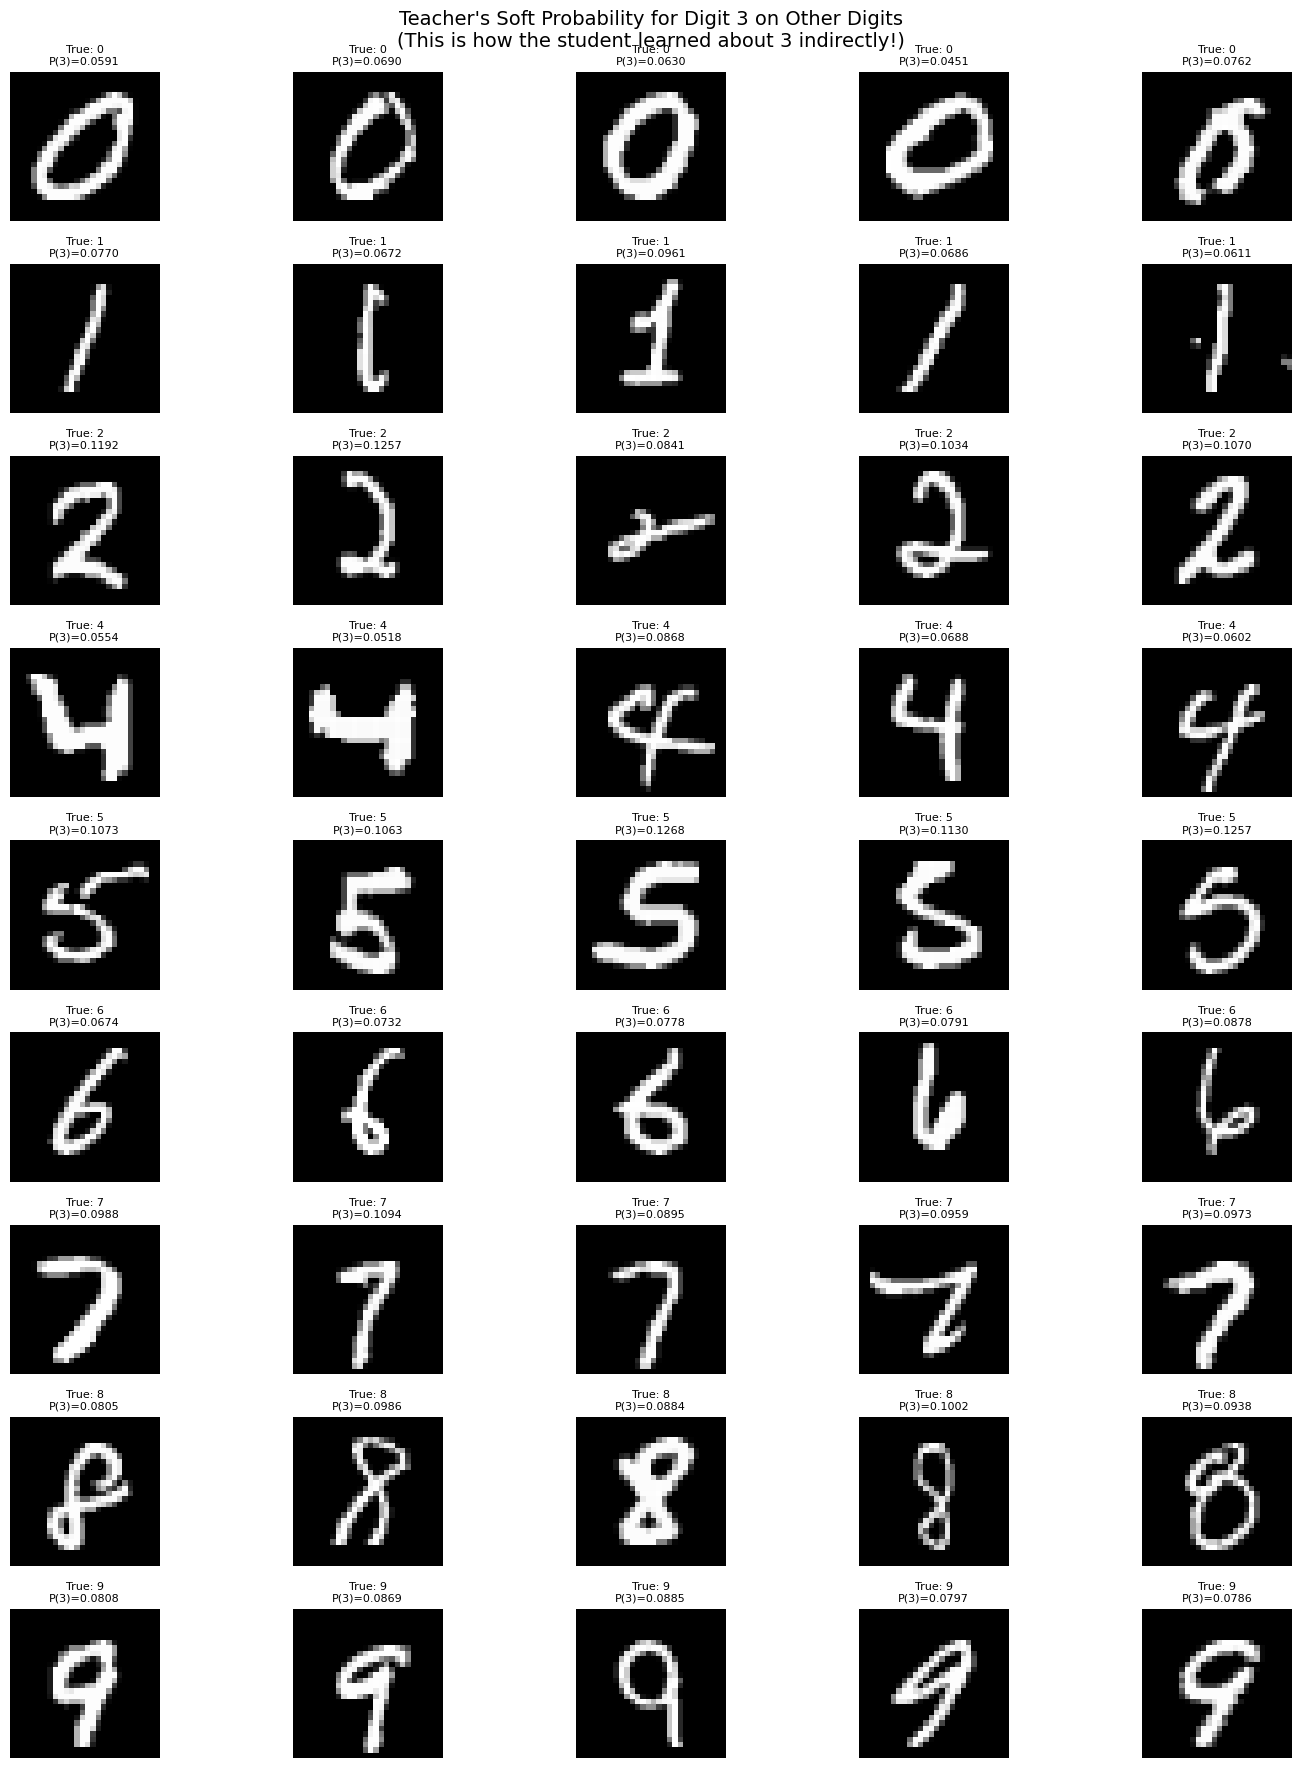

In [18]:
def analyze_soft_targets(teacher, student, dataset, digit, num_examples=5):
    """
    Analyze what soft targets the teacher provided on non-3 digits
    that helped the student learn about 3s.
    """
    teacher.eval()
    student.eval()
    
    # Find examples of other digits (not the target digit)
    other_digits = [d for d in range(10) if d != digit]
    
    fig, axes = plt.subplots(len(other_digits), num_examples, figsize=(15, 18))
    
    with torch.no_grad():
        for row_idx, other_digit in enumerate(other_digits):
            # Find examples of this other digit
            indices = [i for i, (_, label) in enumerate(dataset) if label == other_digit]
            selected_indices = np.random.choice(indices, num_examples, replace=False)
            
            for col_idx, img_idx in enumerate(selected_indices):
                img, true_label = dataset[img_idx]
                img_tensor = img.unsqueeze(0).to(device)
                
                # Get teacher's soft targets at high temperature
                _, teacher_probs = teacher(img_tensor, temperature=20)
                teacher_prob_for_3 = teacher_probs[0, digit].item()
                
                # Show image
                ax = axes[row_idx, col_idx]
                ax.imshow(img.squeeze(), cmap='gray')
                ax.set_title(f'True: {true_label}\nP(3)={teacher_prob_for_3:.4f}', 
                           fontsize=8)
                ax.axis('off')
    
    plt.suptitle(f'Teacher\'s Soft Probability for Digit {digit} on Other Digits\n'
                 f'(This is how the student learned about {digit} indirectly!)', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()

print("=" * 60)
print("ANALYZING HOW THE STUDENT LEARNED ABOUT 3s")
print("=" * 60)
print("\nThe student never saw any 3s during training.")
print("But the teacher provided soft targets on OTHER digits.")
print("Let's see what probability the teacher assigned to '3' on other digits:")
print()

analyze_soft_targets(teacher_model, student_model, train_dataset, digit=3, num_examples=5)

## Cell 13: Plot Training History

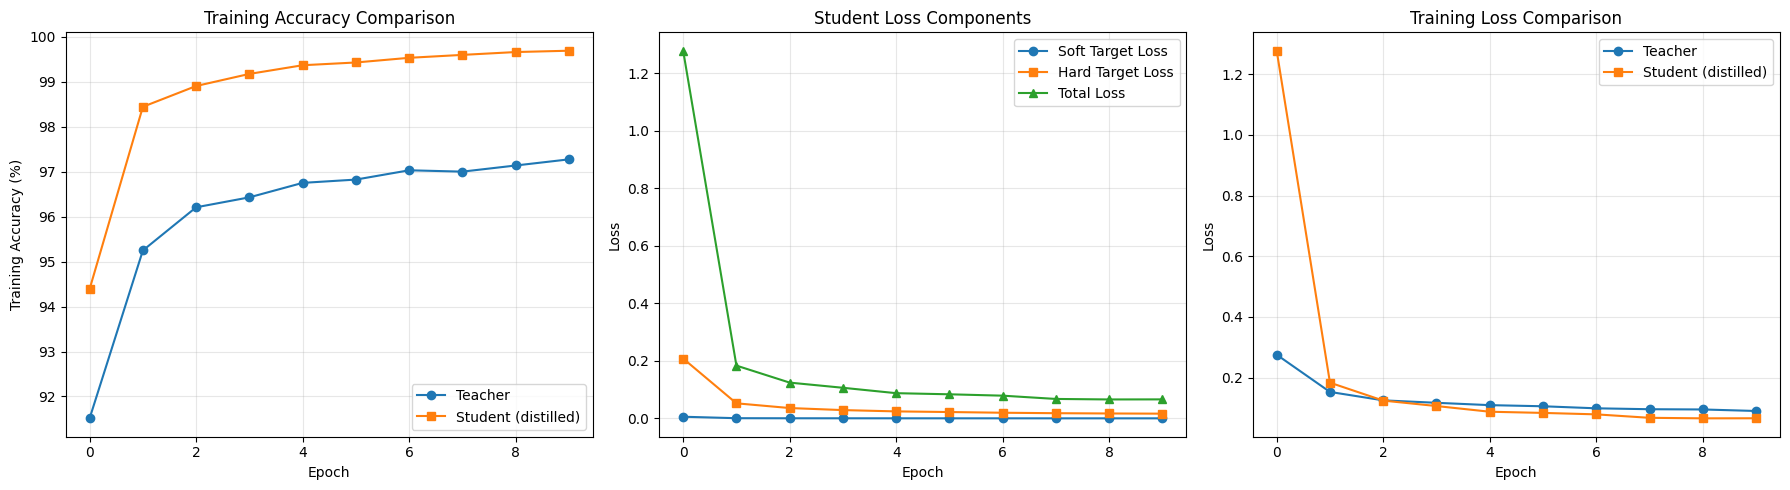

In [19]:
def plot_training_history(teacher_history, student_history):
    """
    Plot training curves for teacher and student.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Training Accuracy
    axes[0].plot(teacher_history['accuracy'], label='Teacher', marker='o')
    axes[0].plot(student_history['accuracy'], label='Student (distilled)', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Accuracy (%)')
    axes[0].set_title('Training Accuracy Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Student Loss Components
    axes[1].plot(student_history['soft_loss'], label='Soft Target Loss', marker='o')
    axes[1].plot(student_history['hard_loss'], label='Hard Target Loss', marker='s')
    axes[1].plot(student_history['total_loss'], label='Total Loss', marker='^')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Student Loss Components')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Teacher vs Student Loss
    axes[2].plot(teacher_history['loss'], label='Teacher', marker='o')
    axes[2].plot(student_history['total_loss'], label='Student (distilled)', marker='s')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Training Loss Comparison')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(teacher_history, student_history)

## Cell 14: Summary and Comparison


In [20]:
print("=" * 80)
print(" " * 20 + "FINAL SUMMARY - MYTHICAL DIGIT EXPERIMENT")
print("=" * 80)
print()
print("TEACHER MODEL (trained on all digits 0-9):")
print(f"  - Architecture: 2 layers × 1200 units")
print(f"  - Training: Dropout + weight regularization")
print(f"  - Test Accuracy: {teacher_acc:.2f}%")
print()
print("STUDENT MODEL (trained WITHOUT digit 3):")
print(f"  - Architecture: 2 layers × 800 units")
print(f"  - Training: Only soft targets from teacher, NO dropout, NO regularization")
print(f"  - Training data: Digits 0,1,2,4,5,6,7,8,9 (no 3s!)")
print(f"  - Test Accuracy: {student_acc:.2f}%")
print()
print("MYTHICAL DIGIT 3 RESULTS:")
print(f"  - Student NEVER saw any 3s during training")
print(f"  - Digit 3 accuracy (no bias): {digit_3_accuracy:.2f}%")
print(f"  - Digit 3 accuracy (with bias={best_bias:+.1f}): {best_digit_3_accuracy:.2f}%")
print()
print("KEY INSIGHT:")
print("  The student learned to recognize 3s purely from the teacher's soft")
print("  probability distributions on OTHER digits! This shows that soft targets")
print("  encode rich relational information about class similarities.")
print()
print("  For example:")
print("  - When teacher sees a '7', it might output [P(7)=0.95, P(3)=0.03, ...]")
print("  - When teacher sees an '8', it might output [P(8)=0.92, P(3)=0.05, ...]")
print("  - From these indirect signals, the student learns what a '3' looks like!")
print("=" * 80)

                    FINAL SUMMARY - MYTHICAL DIGIT EXPERIMENT

TEACHER MODEL (trained on all digits 0-9):
  - Architecture: 2 layers × 1200 units
  - Training: Dropout + weight regularization
  - Test Accuracy: 97.85%

STUDENT MODEL (trained WITHOUT digit 3):
  - Architecture: 2 layers × 800 units
  - Training: Only soft targets from teacher, NO dropout, NO regularization
  - Training data: Digits 0,1,2,4,5,6,7,8,9 (no 3s!)
  - Test Accuracy: 97.79%

MYTHICAL DIGIT 3 RESULTS:
  - Student NEVER saw any 3s during training
  - Digit 3 accuracy (no bias): 93.37%
  - Digit 3 accuracy (with bias=+6.0): 99.90%

KEY INSIGHT:
  The student learned to recognize 3s purely from the teacher's soft
  probability distributions on OTHER digits! This shows that soft targets
  encode rich relational information about class similarities.

  For example:
  - When teacher sees a '7', it might output [P(7)=0.95, P(3)=0.03, ...]
  - When teacher sees an '8', it might output [P(8)=0.92, P(3)=0.05, ...]
  - Fr

In [2]:
"""
the general training framework
"""

from __future__ import print_function

import os
import re
import argparse
import time

import numpy
import torch
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.nn as nn
import torch.backends.cudnn as cudnn
import tensorboard_logger as tb_logger

from models import model_dict
from models.util import ConvReg, SelfA, SRRL, SimKD

from dataset.cifar100 import get_cifar100_dataloaders, get_cifar100_dataloaders_sample
from dataset.imagenet import get_imagenet_dataloader,  get_dataloader_sample
from dataset.imagenet_dali import get_dali_data_loader

from helper.loops import train_distill as train, validate_vanilla, validate_distill
from helper.util import save_dict_to_json, reduce_tensor, adjust_learning_rate

from crd.criterion import CRDLoss
from distiller_zoo import DistillKL, HintLoss, Attention, Similarity, VIDLoss, SemCKDLoss

split_symbol = '~' if os.name == 'nt' else ':'

def parse_option():

    parser = argparse.ArgumentParser('argument for training')
    
    # basic
    parser.add_argument('--print_freq', type=int, default=200, help='print frequency')
    parser.add_argument('--batch_size', type=int, default=64, help='batch_size')
    parser.add_argument('--num_workers', type=int, default=8, help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=240, help='number of training epochs')
    parser.add_argument('--gpu_id', type=str, default='0', help='id(s) for CUDA_VISIBLE_DEVICES')

    # optimization
    parser.add_argument('--learning_rate', type=float, default=0.05, help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='150,180,210', help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1, help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=5e-4, help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9, help='momentum')

    # dataset and model
    parser.add_argument('--dataset', type=str, default='cifar100', choices=['cifar100', 'imagenet'], help='dataset')
    parser.add_argument('--model_s', type=str, default='resnet8x4')
    parser.add_argument('--path_t', type=str, default=None, help='teacher model snapshot')

    # distillation
    parser.add_argument('--trial', type=str, default='1', help='trial id')
    parser.add_argument('--kd_T', type=float, default=4, help='temperature for KD distillation')
    parser.add_argument('--distill', type=str, default='kd', choices=['kd', 'hint', 'attention', 'similarity', 'vid',
                                                                      'crd', 'semckd','srrl', 'simkd'])
    parser.add_argument('-c', '--cls', type=float, default=1.0, help='weight for classification')
    parser.add_argument('-d', '--div', type=float, default=1.0, help='weight balance for KD')
    parser.add_argument('-b', '--beta', type=float, default=0.0, help='weight balance for other losses')
    parser.add_argument('-f', '--factor', type=int, default=2, help='factor size of SimKD')
    parser.add_argument('-s', '--soft', type=float, default=1.0, help='attention scale of SemCKD')

    # hint layer
    parser.add_argument('--hint_layer', default=1, type=int, choices=[0, 1, 2, 3, 4])

    # NCE distillation
    parser.add_argument('--feat_dim', default=128, type=int, help='feature dimension')
    parser.add_argument('--mode', default='exact', type=str, choices=['exact', 'relax'])
    parser.add_argument('--nce_k', default=16384, type=int, help='number of negative samples for NCE')
    parser.add_argument('--nce_t', default=0.07, type=float, help='temperature parameter for softmax')
    parser.add_argument('--nce_m', default=0.5, type=float, help='momentum for non-parametric updates')

    # multiprocessing
    parser.add_argument('--dali', type=str, choices=['cpu', 'gpu'], default=None)
    parser.add_argument('--multiprocessing-distributed', action='store_true',
                    help='Use multi-processing distributed training to launch '
                         'N processes per node, which has N GPUs. This is the '
                         'fastest way to use PyTorch for either single node or '
                         'multi node data parallel training')
    parser.add_argument('--dist-url', default='tcp://127.0.0.1:23451', type=str,
                    help='url used to set up distributed training')
    parser.add_argument('--deterministic', action='store_true', help='Make results reproducible')
    parser.add_argument('--skip-validation', action='store_true', help='Skip validation of teacher')
    
    opt = parser.parse_args()

    # set different learning rates for these MobileNet/ShuffleNet models
    if opt.model_s in ['MobileNetV2', 'MobileNetV2_1_0', 'ShuffleV1', 'ShuffleV2', 'ShuffleV2_1_5']:
        opt.learning_rate = 0.01

    # set the path of model and tensorboard
    opt.model_path = './save/students/models'
    opt.tb_path = './save/students/tensorboard'

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_t = get_teacher_name(opt.path_t)

    model_name_template = split_symbol.join(['S', '{}_T', '{}_{}_{}_r', '{}_a', '{}_b', '{}_{}'])
    opt.model_name = model_name_template.format(opt.model_s, opt.model_t, opt.dataset, opt.distill,
                                                opt.cls, opt.div, opt.beta, opt.trial)

    if opt.dali is not None:
        opt.model_name += '_dali:' + opt.dali

    opt.tb_folder = os.path.join(opt.tb_path, opt.model_name)
    if not os.path.isdir(opt.tb_folder):
        os.makedirs(opt.tb_folder)

    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)
    
    return opt

def get_teacher_name(model_path):
    """parse teacher name"""
    directory = model_path.split('/')[-2]
    pattern = ''.join(['S', split_symbol, '(.+)', '_T', split_symbol])
    name_match = re.match(pattern, directory)
    if name_match:
        return name_match[1]
    segments = directory.split('_')
    if segments[0] == 'wrn':
        return segments[0] + '_' + segments[1] + '_' + segments[2]
    return segments[0]


def load_teacher(model_path, n_cls, gpu=None, opt=None):
    print('==> loading teacher model')
    model_t = get_teacher_name(model_path)
    model = model_dict[model_t](num_classes=n_cls)
    map_location = None if gpu is None else {'cuda:0': 'cuda:%d' % (gpu if opt.multiprocessing_distributed else 0)}
    model.load_state_dict(torch.load(model_path, map_location=map_location)['model'])
    print('==> done')
    return model


best_acc = 0
total_time = time.time()
def main():
    
    opt = parse_option()
    
    # ASSIGN CUDA_ID
    os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_id
    
    ngpus_per_node = torch.cuda.device_count()
    opt.ngpus_per_node = ngpus_per_node
    if opt.multiprocessing_distributed:
        # Since we have ngpus_per_node processes per node, the total world_size
        # needs to be adjusted accordingly
        world_size = 1
        opt.world_size = ngpus_per_node * world_size
        # Use torch.multiprocessing.spawn to launch distributed processes: the
        # main_worker process function
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, opt))
    else:
        main_worker(None if ngpus_per_node > 1 else opt.gpu_id, ngpus_per_node, opt)

def main_worker(gpu, ngpus_per_node, opt):
    global best_acc, total_time
    opt.gpu = int(gpu)
    opt.gpu_id = int(gpu)

    if opt.gpu is not None:
        print("Use GPU: {} for training".format(opt.gpu))

    if opt.multiprocessing_distributed:
        # Only one node now.
        opt.rank = gpu
        dist_backend = 'nccl'
        dist.init_process_group(backend=dist_backend, init_method=opt.dist_url,
                                world_size=opt.world_size, rank=opt.rank)
        opt.batch_size = int(opt.batch_size / ngpus_per_node)
        opt.num_workers = int((opt.num_workers + ngpus_per_node - 1) / ngpus_per_node)

    if opt.deterministic:
        torch.manual_seed(12345)
        cudnn.deterministic = True
        cudnn.benchmark = False
        numpy.random.seed(12345)

    # model
    n_cls = {
        'cifar100': 100,
        'imagenet': 1000,
    }.get(opt.dataset, None)
    
    model_t = load_teacher(opt.path_t, n_cls, opt.gpu, opt)
    try:
        model_s = model_dict[opt.model_s](num_classes=n_cls)
    except KeyError:
        print("This model is not supported.")

    if opt.dataset == 'cifar100':
        data = torch.randn(2, 3, 32, 32)
    elif opt.dataset == 'imagenet':
        data = torch.randn(2, 3, 224, 224)

    model_t.eval()
    model_s.eval()
    feat_t, _ = model_t(data, is_feat=True)
    feat_s, _ = model_s(data, is_feat=True)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(opt.kd_T)
    if opt.distill == 'kd':
        criterion_kd = DistillKL(opt.kd_T)
    elif opt.distill == 'hint':
        criterion_kd = HintLoss()
        regress_s = ConvReg(feat_s[opt.hint_layer].shape, feat_t[opt.hint_layer].shape)
        module_list.append(regress_s)
        trainable_list.append(regress_s)
    elif opt.distill == 'attention':
        criterion_kd = Attention()
    elif opt.distill == 'similarity':
        criterion_kd = Similarity()
    elif opt.distill == 'vid':
        s_n = [f.shape[1] for f in feat_s[1:-1]]
        t_n = [f.shape[1] for f in feat_t[1:-1]]
        criterion_kd = nn.ModuleList(
            [VIDLoss(s, t, t) for s, t in zip(s_n, t_n)]
        )
        # add this as some parameters in VIDLoss need to be updated
        trainable_list.append(criterion_kd)
    elif opt.distill == 'crd':
        opt.s_dim = feat_s[-1].shape[1]
        opt.t_dim = feat_t[-1].shape[1]
        if opt.dataset == 'cifar100':
            opt.n_data = 50000
        else:
            opt.n_data = 1281167
        criterion_kd = CRDLoss(opt)
        module_list.append(criterion_kd.embed_s)
        module_list.append(criterion_kd.embed_t)
        trainable_list.append(criterion_kd.embed_s)
        trainable_list.append(criterion_kd.embed_t)
    elif opt.distill == 'semckd':
        s_n = [f.shape[1] for f in feat_s[1:-1]]
        t_n = [f.shape[1] for f in feat_t[1:-1]]
        criterion_kd = SemCKDLoss()
        self_attention = SelfA(opt.batch_size, s_n, t_n, opt.soft)    
        module_list.append(self_attention)
        trainable_list.append(self_attention)
    elif opt.distill == 'srrl':
        s_n = feat_s[-1].shape[1]
        t_n = feat_t[-1].shape[1]
        model_fmsr = SRRL(s_n= s_n, t_n=t_n)
        criterion_kd = nn.MSELoss()
        module_list.append(model_fmsr)
        trainable_list.append(model_fmsr)
    elif opt.distill == 'simkd':
        s_n = feat_s[-2].shape[1]
        t_n = feat_t[-2].shape[1]
        model_simkd = SimKD(s_n= s_n, t_n=t_n, factor=opt.factor)
        criterion_kd = nn.MSELoss()
        module_list.append(model_simkd)
        trainable_list.append(model_simkd)
    else:
        raise NotImplementedError(opt.distill)

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    module_list.append(model_t)
    
    optimizer = optim.SGD(trainable_list.parameters(),
                          lr=opt.learning_rate,
                          momentum=opt.momentum,
                          weight_decay=opt.weight_decay)

    if torch.cuda.is_available():
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if opt.multiprocessing_distributed:
            if opt.gpu is not None:
                torch.cuda.set_device(opt.gpu)
                module_list.cuda(opt.gpu)
                distributed_modules = []
                for module in module_list:
                    DDP = torch.nn.parallel.DistributedDataParallel
                    distributed_modules.append(DDP(module, device_ids=[opt.gpu]))
                module_list = distributed_modules
                criterion_list.cuda(opt.gpu)
            else:
                print('multiprocessing_distributed must be with a specifiec gpu id')
        else:
            criterion_list.cuda()
            module_list.cuda()
        if not opt.deterministic:
            cudnn.benchmark = True

    # dataloader
    if opt.dataset == 'cifar100':
        if opt.distill in ['crd']:
            train_loader, val_loader, n_data = get_cifar100_dataloaders_sample(batch_size=opt.batch_size,
                                                                               num_workers=opt.num_workers,
                                                                               k=opt.nce_k,
                                                                               mode=opt.mode)
        else:
            train_loader, val_loader = get_cifar100_dataloaders(batch_size=opt.batch_size,
                                                                        num_workers=opt.num_workers)
    elif opt.dataset == 'imagenet':
        if opt.dali is None:
            if opt.distill in ['crd']:
                train_loader, val_loader, n_data, _, train_sampler = get_dataloader_sample(dataset=opt.dataset, batch_size=opt.batch_size, 
                                                                                num_workers=opt.num_workers, 
                                                                                is_sample=True, 
                                                                                k=opt.nce_k,
                                                                                multiprocessing_distributed=opt.multiprocessing_distributed)
            else:
                train_loader, val_loader, train_sampler = get_imagenet_dataloader(dataset=opt.dataset, batch_size=opt.batch_size,
                                                                        num_workers=opt.num_workers,
                                                                        multiprocessing_distributed=opt.multiprocessing_distributed)
        else:
            train_loader, val_loader = get_dali_data_loader(opt)
    else:
        raise NotImplementedError(opt.dataset)

    if not opt.multiprocessing_distributed or opt.rank % ngpus_per_node == 0:
        logger = tb_logger.Logger(logdir=opt.tb_folder, flush_secs=2)

    if not opt.skip_validation:
        # validate teacher accuracy
        teacher_acc, _, _ = validate_vanilla(val_loader, model_t, criterion_cls, opt)

        if opt.dali is not None:
            val_loader.reset()

        if not opt.multiprocessing_distributed or opt.rank % ngpus_per_node == 0:
            print('teacher accuracy: ', teacher_acc)
    else:
        print('Skipping teacher validation.')
    
    # routine
    for epoch in range(1, opt.epochs + 1):
        torch.cuda.empty_cache()
        if opt.multiprocessing_distributed:
            if opt.dali is None:
                train_sampler.set_epoch(epoch)

        adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_acc_top5, train_loss = train(epoch, train_loader, module_list, criterion_list, optimizer, opt)
        time2 = time.time()

        if opt.multiprocessing_distributed:
            metrics = torch.tensor([train_acc, train_acc_top5, train_loss]).cuda(opt.gpu, non_blocking=True)
            reduced = reduce_tensor(metrics, opt.world_size if 'world_size' in opt else 1)
            train_acc, train_acc_top5, train_loss = reduced.tolist()

        if not opt.multiprocessing_distributed or opt.rank % ngpus_per_node == 0:
            print(' * Epoch {}, GPU {}, Acc@1 {:.3f}, Acc@5 {:.3f}, Time {:.2f}'.format(epoch, opt.gpu, train_acc, train_acc_top5, time2 - time1))
            
            logger.log_value('train_acc', train_acc, epoch)
            logger.log_value('train_loss', train_loss, epoch)

        print('GPU %d validating' % (opt.gpu))
        test_acc, test_acc_top5, test_loss = validate_distill(val_loader, module_list, criterion_cls, opt)        

        if opt.dali is not None:
            train_loader.reset()
            val_loader.reset()

        if not opt.multiprocessing_distributed or opt.rank % ngpus_per_node == 0:
            print(' ** Acc@1 {:.3f}, Acc@5 {:.3f}'.format(test_acc, test_acc_top5))
            
            logger.log_value('test_acc', test_acc, epoch)
            logger.log_value('test_loss', test_loss, epoch)
            logger.log_value('test_acc_top5', test_acc_top5, epoch)

            # save the best model
            if test_acc > best_acc:
                best_acc = test_acc
                state = {
                    'epoch': epoch,
                    'model': model_s.state_dict(),
                    'best_acc': best_acc,
                }
                if opt.distill == 'simkd':
                    state['proj'] = trainable_list[-1].state_dict() 
                save_file = os.path.join(opt.save_folder, '{}_best.pth'.format(opt.model_s))
                
                test_merics = {'test_loss': test_loss,
                                'test_acc': test_acc,
                                'test_acc_top5': test_acc_top5,
                                'epoch': epoch}
                
                save_dict_to_json(test_merics, os.path.join(opt.save_folder, "test_best_metrics.json"))
                print('saving the best model!')
                torch.save(state, save_file)
            
    if not opt.multiprocessing_distributed or opt.rank % ngpus_per_node == 0:
        # This best accuracy is only for printing purpose.
        print('best accuracy:', best_acc)
        
        # save parameters
        save_state = {k: v for k, v in opt._get_kwargs()}
        # No. parameters(M)
        num_params = (sum(p.numel() for p in model_s.parameters())/1000000.0)
        save_state['Total params'] = num_params
        save_state['Total time'] =  (time.time() - total_time)/3600.0
        params_json_path = os.path.join(opt.save_folder, "parameters.json") 
        save_dict_to_json(save_state, params_json_path)

if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'models'